## Assignment 4

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

font = {'size': 16}

matplotlib.rc('font', **font)

### 1. Generalized linear model: Bioassay + grid sampling

#### a) Repeat all the computations and plots of Section 3.7 with this new prior distribution

We compute the prioer destribution given the distribution of $\alpha$ and $\beta$ - we use the formula [1] witk $k = 2$:

$$
{\displaystyle {\begin{aligned}f_{\mathbf {X} }(x_{1},\ldots ,x_{k})&={\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu }})^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}({\mathbf {x} }-{\boldsymbol {\mu }})\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}\end{aligned}}}
$$

From the text we get means, $\mu$, and covariance matrix $\Sigma$.

In [35]:
mu  = np.array([0, 10])
cov = np.array([
    [        2**2, 2 * 10 * 0.5],
    [2 * 10 * 0.5,        10**2]
])
print('mu  = ' + str(mu))
print('cov = \n' + str(cov))

mu  = [ 0 10]
cov = 
[[   4.   10.]
 [  10.  100.]]


We calculate the prior distribution:

In [36]:
prior = stats.multivariate_normal(mu, cov)

We plot the prior using a density contour and heatmap

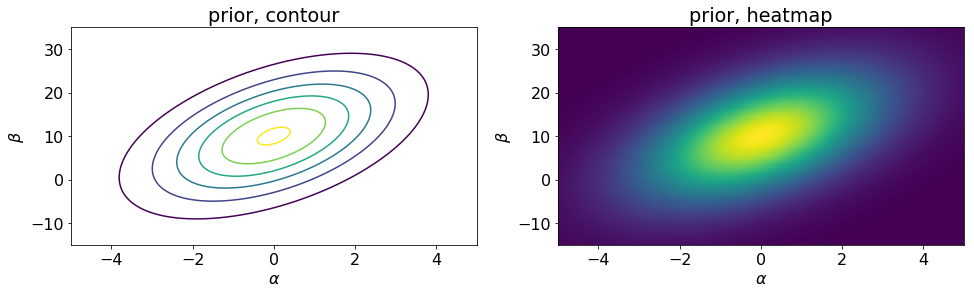

In [236]:
alpha, beta = np.mgrid[-5:5:200j, -15:35:200j]
grid = np.empty(alpha.shape + (2,))
grid[:, :, 0] = alpha; grid[:, :, 1] = beta
A = alpha[:,0]
B = beta[0,:]
W = np.array([alpha[0,0], alpha[-1,0], beta[0,0], beta[0,-1]])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 4))

ax[0].contour(alpha, beta, prior.pdf(grid))
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].set_title('prior, contour')

ax[1].imshow(prior.pdf(grid).T, origin='lower', aspect='auto', extent = tuple(W), interpolation='none')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_title('prior, heatmap')

None

**Compute the posterior density at a grid of points $(\alpha, \beta)$**

We use the same data as given in the book (table 3.1)

In [214]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

df = pd.DataFrame({
    'Sample': np.arange(4) + 1,
    'Dose (log g/ml)': x,
    'Number of animals': n,
    'Number of deaths': y
}).set_index('Sample')
df

,Dose (log g/ml),Number of animals,Number of deaths
Sample,,,
1,-0.86,5,0
2,-0.30,5,1
3,-0.05,5,3
4,0.73,5,5


We calculate the log-posterior as the sum of the log-prior and the log-likelihood:

In [267]:
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
likelihood = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)
log_likelihood = np.sum(np.log(ilogit_abx**y) + np.log((1 - ilogit_abx)**(n - y)), axis=2)
p = log_likelihood + np.log(prior.pdf(grid))
p = p - p.max()
p = np.exp(p)
p = p / np.sum(p)

We plot the likelihood and posterier:

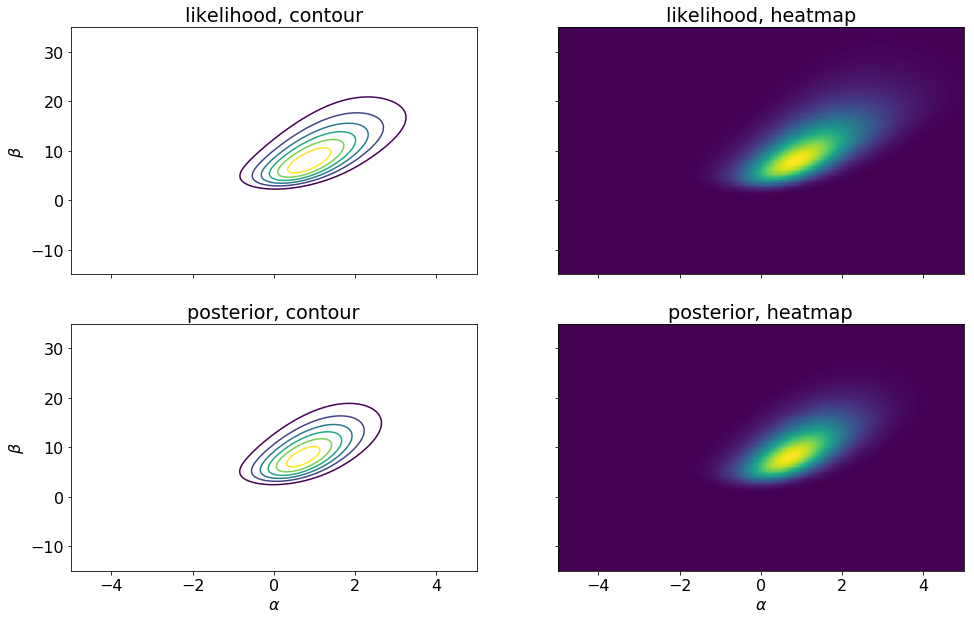

In [268]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (16, 10), sharex = True, sharey = True)

ax[0,0].contour(alpha, beta, likelihood.T)
ax[0,0].set_ylabel(r'$\beta$')
ax[0,0].set_title('likelihood, contour')

ax[0,1].imshow(likelihood, origin='lower', aspect='auto', extent = tuple(W), interpolation='none')
ax[0,1].set_title('likelihood, heatmap')

ax[1,0].contour(alpha, beta, p.T)
ax[1,0].set_xlabel(r'$\alpha$')
ax[1,0].set_ylabel(r'$\beta$')
ax[1,0].set_title('posterior, contour')

ax[1,1].imshow(p, origin='lower', aspect='auto', extent = tuple(W), interpolation='none')
ax[1,1].set_xlabel(r'$\alpha$')
ax[1,1].set_title('posterior, heatmap')

None

Use the grid to sample 1000 draws from the posterior

In [308]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

Draw a posterior contour plot for the parameters $\alpha$ and $\beta$ (see Figure 3.3a) and Draw a scatterplot of the 1000 draws from the posterior (see Figure 3.3b)

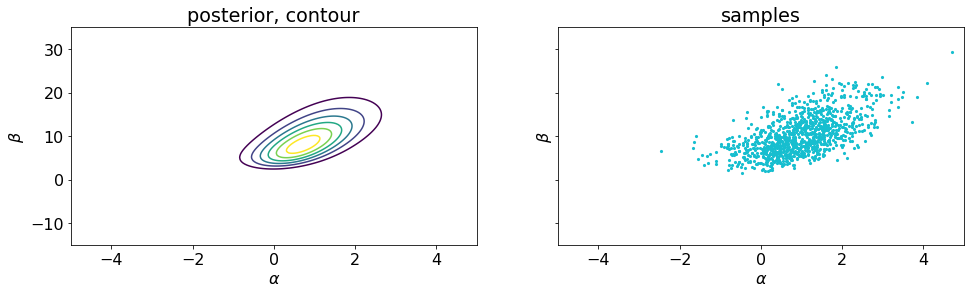

In [309]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 4), sharex = True, sharey = True)

ax[0].contour(alpha, beta, p.T)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].set_title('posterior, contour')

# plot the samples
ax[1].scatter(samp_A, samp_B, 10, linewidth=0, color='C9')
ax[1].set_xlim(tuple(W[0:2]))
ax[1].set_ylim(tuple(W[2:4]))
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_title('samples')

None

Draw a histogram of the draws from the posterior distribution of the LD50 conditional on $\beta > 0$ (see Figure 3.4)

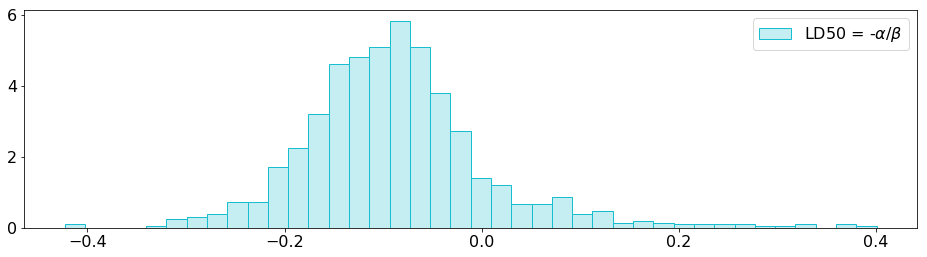

In [310]:
fig, ax = plt.subplots(figsize = (16, 4))
ax.hist(samp_ld50, normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, label = r'LD50 = -$\alpha/\beta$', edgecolor='C9')
ax.legend(loc = 'upper right')
None

**b) Check visually that your contour plot and scatter plot look like a compromise between the prior
distribution and the likelihood**

We plot the three contours side by side:

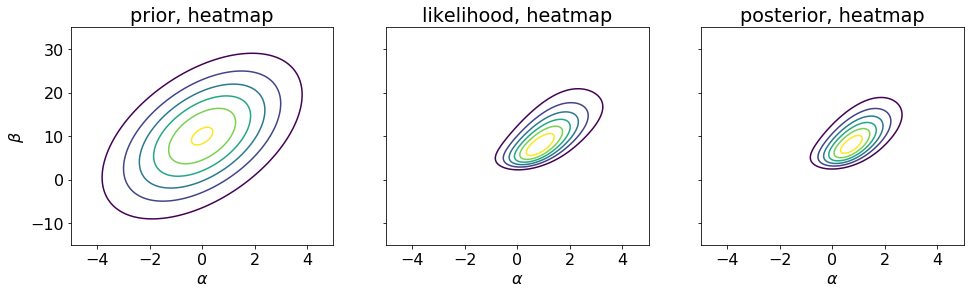

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16, 4), sharex = True, sharey = True)

ax[0].contour(alpha, beta, prior.pdf(grid))
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].set_title('prior, heatmap')

ax[1].contour(alpha, beta, likelihood.T)
ax[1].set_title('likelihood, heatmap')
ax[1].set_xlabel(r'$\alpha$')

ax[2].contour(alpha, beta, p.T)
ax[2].set_xlabel(r'$\alpha$')
ax[2].set_title('posterior, heatmap')

None

We see that both the contour plot and scatter plot look like a compromise between the prior distribution and the likelihood, e.g. the likelihhood has added information to the prior to produce the posterior. The mean for both alpha and beta in the posterior is between the mean for the prior and the likehood:

In [304]:
likelihood_indices = np.unravel_index(
    np.random.choice(likelihood.size, size=nsamp, p=likelihood.ravel()/np.sum(likelihood)),
    p.shape
)
likelihood_A = A[likelihood_indices[1]]
likelihood_B = B[likelihood_indices[0]]

print('Prior mean:        alpha: {:>6.3f}   beta: {:>6.3f}'.format(*list(prior.mean)))
print('Likelihood mean:   alpha: {:>6.3f}   beta: {:>6.3f}'.format(likelihood_A.mean(), likelihood_B.mean()))
print('Posterior mean:    alpha: {:>6.3f}   beta: {:>6.3f}'.format(samp_A.mean(), samp_B.mean()))

Prior mean:        alpha:  0.000   beta: 10.000
Likelihood mean:   alpha:  1.256   beta: 11.367
Posterior mean:    alpha:  0.997   beta: 10.571


We conclude that it seems like a good compromise.

**c) Report an estimate for p(β > 0|x,n,y), that is, the probability that the drug is harmful**

All of the 1000 draws has positive value of $\beta$ - so the posterior probability that $\beta > 0$ is roughly estimated to exceed 0.999.

In [311]:
bpi.mean()

1.0

### References
[1] Multivariate normal distribution, https://en.wikipedia.org/wiki/Multivariate_normal_distribution